In [1]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPModel, CLIPProcessor
import transformer_lens
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from urllib.request import urlretrieve
import pandas as pd

# Download the parquet table
# table_url = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/metadata.parquet'
# urlretrieve(table_url, 'metadata.parquet')
# Read the table using Pandas
metadata_df = pd.read_parquet('metadata.parquet')
print(metadata_df.shape)
metadata_df.head()

(2000000, 13)


image_name  \
0  2217ccbd-a1c6-47ac-9a2d-79649727c834.png   
1  c78807b7-d55a-4a2d-a6b6-9192b18941ad.png   
2  dc71658a-5e4b-4dca-861a-e1535510348b.png   
3  48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png   
4  601d9792-eccd-4850-97a7-edbe91d3464c.png   

                                              prompt  part_id        seed  \
0  a portrait of a female robot made from code, v...        1  2615452544   
1  a portrait of a female robot made from a cloud...        1  4231506957   
2      only memories remain, trending on artstation         1   544607824   
3                   dream swimming pool with nobody         1  3500509234   
4           a dog doing weights. epic oil painting.         1  1312381211   

   step   cfg  sampler  width  height  \
0    50   7.0        8    512     512   
1    50   7.0        8    512     512   
2    50   7.0        8    512     512   
3    50   7.0        8    512     512   
4    50  12.0        8    512     768   

                                           user_name  \
0  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...   
1  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...   
2  0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...   
3  019084defdd44d2dfcd200bf7aaae53034263168e10d6b...   
4  03cb377ebf364ea2761b5710625974c0d2d25285fec982...   

                  timestamp  image_nsfw  prompt_nsfw  
0 2022-08-20 11:56:00+00:00    0.554853     0.001621  
1 2022-08-20 11:59:00+00:00    0.153645     0.000707  
2 2022-08-20 12:02:00+00:00    0.062496     0.000425  
3 2022-08-20 07:22:00+00:00    0.030799     0.003586  
4 2022-08-20 12:28:00+00:00    0.181035     0.030822

In [4]:
# Get just the prompts, and sample 1000 of them
prompts = metadata_df['prompt'].sample(1000).tolist()
print(f"Prompts are of type {type(prompts)} and length {len(prompts)}")

Prompts are of type <class 'list'> and length 1000


In [5]:
from tqdm import tqdm_notebook as tqdm

In [123]:
prompt = prompts[0]
# Get hidden_states and final_output
tokens = processor(prompt, return_tensors="pt").to(device)
output = model.text_model(**tokens, output_hidden_states=True)
hidden_states = output.hidden_states
final_output = output.last_hidden_state


RuntimeError: The size of tensor a (80) must match the size of tensor b (77) at non-singleton dimension 1

In [33]:
tokens.input_ids.shape[1]

72

In [124]:
# print a subset of the last hidden state
print(final_output[0, :10, :10])
# print a subset of the last hidden state in hidden_states
# print(hidden_states[-1][0, :10, :10])
# Get the final layer norm of the model
layer_norm = model.text_model.final_layer_norm
# Run the last hidden state through the layer norm
layer_norm_output = layer_norm(hidden_states[-1])
# print a subset of the layer norm output
print(layer_norm_output[0, :10, :10])

tensor([[-0.3884,  0.0229, -0.0522, -0.1841, -0.0273, -0.3355, -0.0176, -0.1869,
          0.1877, -0.0907],
        [ 0.0290, -1.3258,  0.3085, -0.0615,  0.0398, -0.7107, -0.9693, -0.4861,
         -0.8043,  0.5238],
        [ 1.1565,  0.1318,  0.7895,  0.9220,  2.0002, -0.4552, -1.9908, -0.4125,
         -0.7500,  0.1742],
        [ 0.1627, -0.0965,  0.8775, -0.1414,  0.6146,  0.5547, -1.7618,  0.1499,
         -0.7053, -0.2120],
        [ 0.1885, -0.1638,  2.2369, -0.4704,  1.1297, -0.1037, -1.4546, -1.8731,
         -0.8492, -0.6785],
        [ 0.7206,  1.3061,  0.7257,  2.2980,  0.0949,  1.0176,  0.9433, -0.0302,
         -0.5653,  1.1358],
        [-1.0987, -1.0655,  0.1411,  2.1943, -0.5354,  1.1309, -1.1628,  0.9793,
          1.1833, -0.8928],
        [-1.4091,  0.7166,  0.2507,  1.0121, -0.2096,  1.3654, -0.4176, -0.4843,
         -0.0157, -1.3171],
        [-2.7212, -0.2221,  0.9881,  0.2688,  0.3721,  1.1178, -0.9710, -0.5158,
          1.5130, -0.7322],
        [-2.2087, -

In [18]:
import torch.nn.functional as F

# dataloader = ["According to all known laws of aviation, there is no way a bee should be able to fly."]
dataloader = metadata_df['prompt'].sample(10000).tolist()
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
final_ln = model.text_model.final_layer_norm

lens = [torch.nn.Linear(768, 768) for _ in range(12)]

def train_lens(model, lens):
    # SGD
    optimizer = torch.optim.Adam([len.weight for len in lens], lr=0.001)

    # Freeze all of the model parameters
    for param in model.parameters():
        param.requires_grad = False

    for data in tqdm(dataloader):
        # Run the model
        tokens = processor.tokenizer(data, return_tensors="pt").to(device=device)
        # Check if the token length is greater than 77. If it is, skip it.
        if tokens.input_ids.shape[1] >= 77:
            continue
        optimizer.zero_grad()
        output = model.text_model(**tokens, output_hidden_states=True)
        hidden_states = output.hidden_states
        final_output = output.last_hidden_state.log_softmax(dim=-1)

        # Remove the embedding layer
        hidden_states = hidden_states[1:]
        for i, hidden_state in enumerate(hidden_states):
            # if i != 6:
                # continue
            tuned_hidden_state = lens[i](final_ln(hidden_state)).log_softmax(dim=-1)
            # Calculate the KL loss
            loss = F.kl_div(tuned_hidden_state, final_output, log_target=True, reduction='mean')
            loss.backward()
        optimizer.step()

# Print a sample set of parameters from lens
print(lens[6].weight[0, :5])
train_lens(model, lens)
print(lens[6].weight[0, :5])

tensor([ 0.0301, -0.0185,  0.0065, -0.0272, -0.0149], grad_fn=<SliceBackward0>)


/var/folders/50/9w9lw_k91plgxbkdgbjrr2zw0000gn/T/ipykernel_48064/3158458166.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(dataloader):


  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/clementneo/projects/aan/aan/lib/python3.10/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (114 > 77). Running this sequence through the model will result in indexing errors


tensor([ 0.5317,  0.0031, -0.0163, -0.0189,  0.0022], grad_fn=<SliceBackward0>)


In [19]:
import torch.nn.functional as F

# Get a test set of 100 prompts
test_prompts = metadata_df['prompt'].sample(100).tolist()

# For each layer, calculate the KL loss
len_kl_losses = {x: [] for x in range(len(lens))}
raw_kl_losses = {x: [] for x in range(len(lens))}
for test_prompt in test_prompts:
    for i, lense in enumerate(lens):
        # if i != 6:
            # continue
        # Calculate the KL loss
        tokens = processor.tokenizer(test_prompt, return_tensors="pt").to(device=device)
        if tokens.input_ids.shape[1] >= 77:
            continue
        output = model.text_model(**tokens, output_hidden_states=True)
        hidden_states = output.hidden_states
        final_output = output.last_hidden_state

        # Remove the embedding layer
        hidden_states = hidden_states[1:]
        tuned_hidden_state = lense(hidden_states[i])
        labels = final_output.log_softmax(dim=-1)
        # kl1 = (labels.exp() * (labels - final_ln(hidden_states[i]).log_softmax(dim=-1))).mean()
        # Calculate the KL loss
        raw_loss = F.kl_div(final_ln(hidden_states[i]).log_softmax(dim=-1), labels, log_target=True, reduction="mean")
        raw_kl_losses[i].append(raw_loss.item())
        tuned_loss = F.kl_div(final_ln(tuned_hidden_state).log_softmax(dim=-1), labels, log_target=True, reduction="mean")
        len_kl_losses[i].append(tuned_loss.item())

Raw KL Losses: {0: [0.001166152418591082, 0.0020576119422912598, 0.002981375902891159, 0.0034811918158084154, 0.002628710586577654, 0.004672052338719368, 0.003469405695796013, 0.0014249749947339296, 0.004007060080766678, 0.0037412650417536497, 0.0034569534473121166, 0.005411787424236536, 0.005286343861371279, 0.001483518281020224, 0.005090159364044666, 0.002029989380389452, 0.001523385290056467, 0.004433833062648773, 0.001842621946707368, 0.0012972073163837194, 0.002135318238288164, 0.001801756676286459, 0.0016098484629765153, 0.0025294178631156683, 0.0016990487929433584, 0.003929797559976578, 0.0022944083902984858, 0.001470821094699204, 0.0019670131150633097, 0.001398377469740808, 0.005162954796105623, 0.0014782586367800832, 0.0034283227287232876, 0.001967001473531127, 0.0032054977491497993, 0.0017179719870910048, 0.003056604415178299, 0.001554351532831788, 0.004422020632773638, 0.0018709090072661638, 0.0032481211237609386, 0.0022587450221180916, 0.0013126763515174389, 0.0025276995729

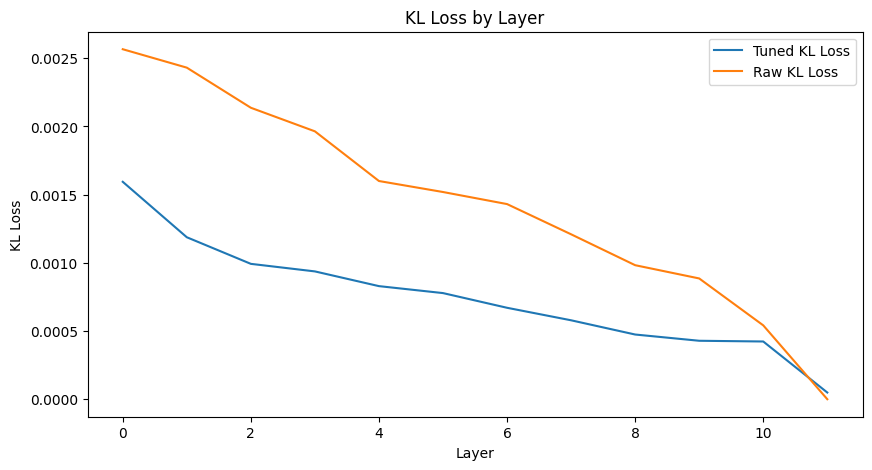

In [20]:
print(f"Raw KL Losses: {raw_kl_losses}")
print(f"Tuned KL Losses: {len_kl_losses}")
# Print the average KL loss for layer 6
print(f"Raw KL Loss: {round(sum(raw_kl_losses[6]) / len(raw_kl_losses[6]), 5)}")
print(f"Tuned KL Loss: {round(sum(len_kl_losses[6]) / len(len_kl_losses[6]), 5)}")
# Graph the KL losses by the layer
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(list(len_kl_losses.keys()), [sum(x) / len(x) for x in len_kl_losses.values()], label="Tuned KL Loss")
plt.plot(list(raw_kl_losses.keys()), [sum(x) / len(x) for x in raw_kl_losses.values()], label="Raw KL Loss")
plt.legend()
plt.xlabel("Layer")
plt.ylabel("KL Loss")
plt.title("KL Loss by Layer")
plt.show()

In [10]:
# StableDiffusion
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

# First-time "warmup" pass (see explanation above)
_ = pipe("warmup", num_inference_steps=1)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/Users/clementneo/projects/aan/aan/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


In [14]:
# prompt = "a photo of an astronaut riding a horse on mars"

# Disable NSFW filtering
pipe.safety_checker = lambda images, **kwargs: (images, False)

# Generate 1 image
# images = pipe(prompt, num_inference_steps=25)

# Display the image
# display(images.images[0])


NameError: name 'prompt' is not defined

In [26]:
prompt = "a photo of an astronaut riding a horse on mars"

ln_hidden_states = []
ln_tuned_hidden_states = []

# Run the prompt through the text model and get the hidden states
tokens = processor.tokenizer(prompt, return_tensors="pt").to(device=device)
output = model.text_model(**tokens, output_hidden_states=True)
hidden_states = output.hidden_states
final_output = output.last_hidden_state

# Remove the embedding layer
hidden_states = hidden_states[1:]

# For each layer, run the hidden state through final layer norm
for hidden_state in hidden_states:
    ln_hidden_states.append(final_ln(hidden_state))

# For each layer, run the hidden state through the tuned linear layer
for i, hidden_state in enumerate(hidden_states):
    tuned_hidden_state = lens[i](hidden_state)
    ln_tuned_hidden_states.append(final_ln(tuned_hidden_state))

In [21]:
# ln_tuned_hidden_states = []

# For each layer, run the hidden state through the tuned linear layer
for i, hidden_state in enumerate(hidden_states):
    tuned_hidden_state = lens[i](hidden_state)
    ln_tuned_hidden_states.append(final_ln(tuned_hidden_state))

# tuned_hidden_state_2 = lens[-1]()

In [113]:
raw_images = []
tuned_images = []

# For each layer, run the hidden state through the image model
for i, hidden_state in tqdm(enumerate(ln_hidden_states)):
    image = pipe(prompt_embeds=hidden_state, num_inference_steps=25)
    raw_images.append(image.images[0])

/var/folders/50/9w9lw_k91plgxbkdgbjrr2zw0000gn/T/ipykernel_34855/1216971297.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, hidden_state in tqdm(enumerate(ln_hidden_states)):


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

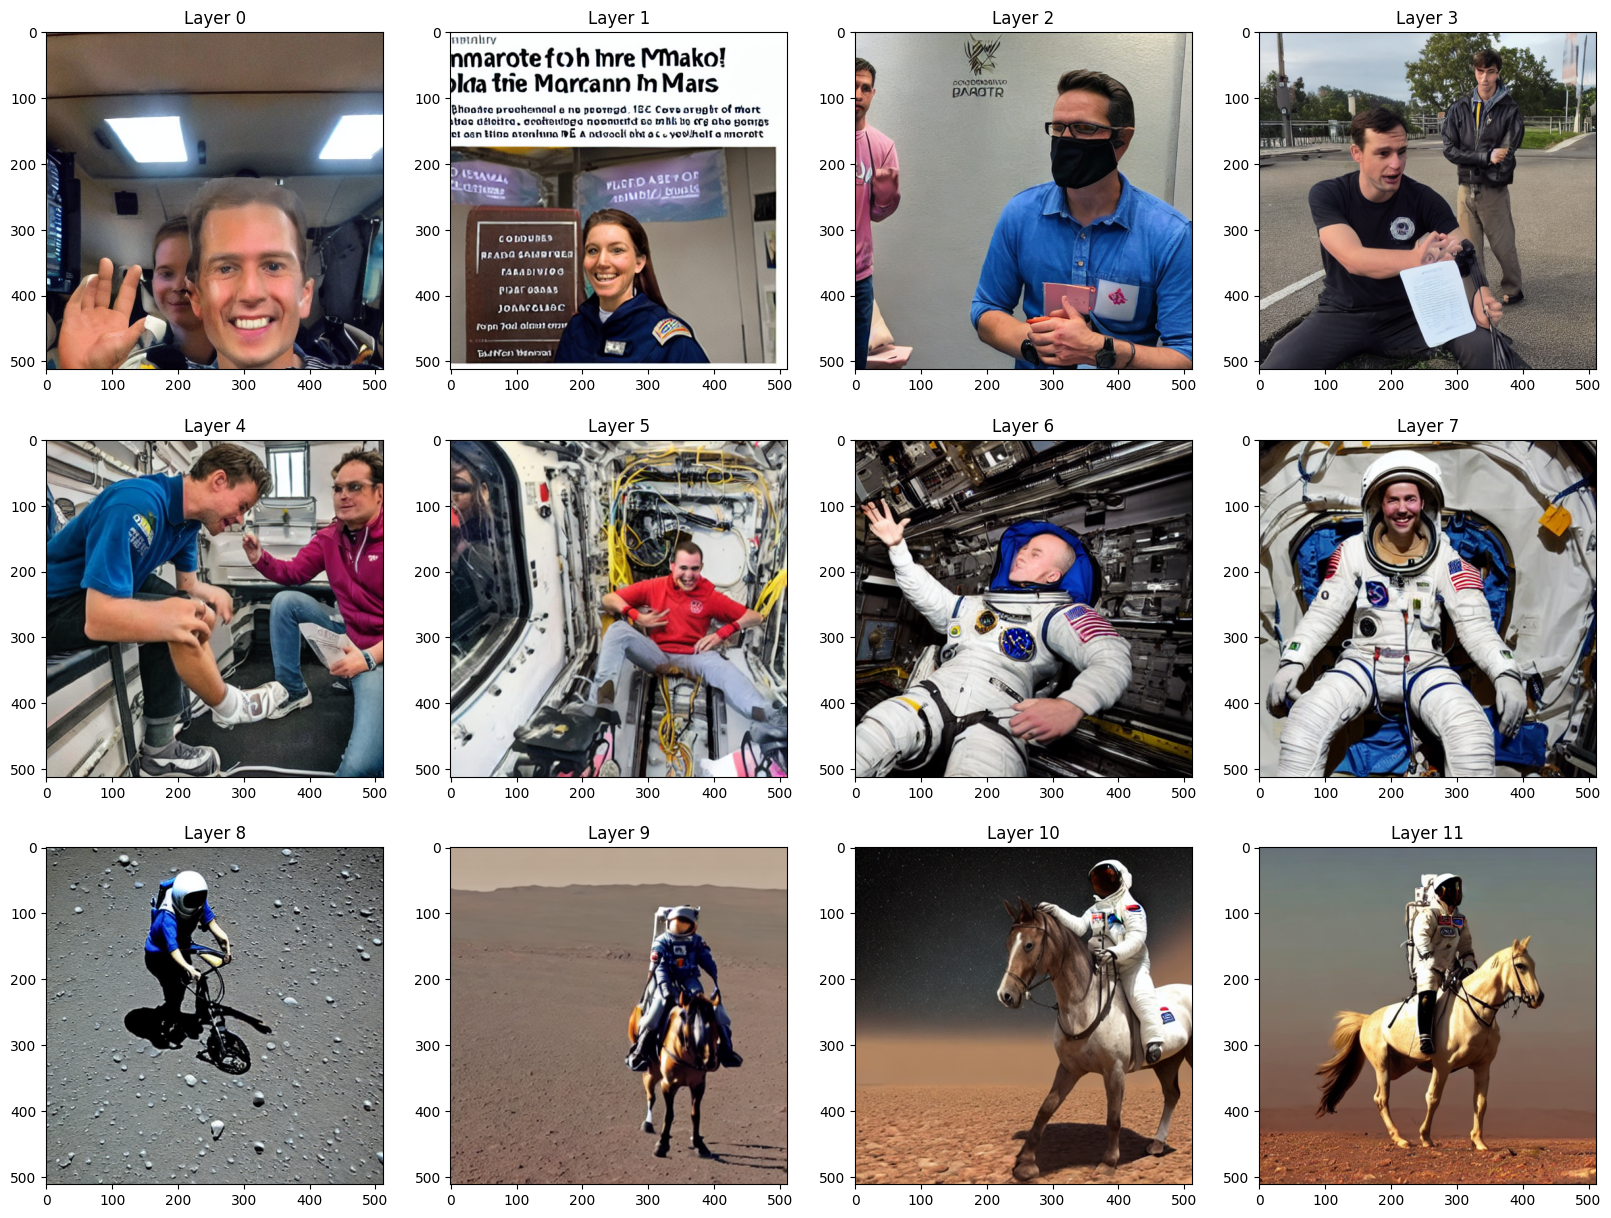

In [114]:
# Code to plot all 12 images in a grid
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(raw_images[i])
    ax.set_title(f"Layer {i}")
plt.show()

In [29]:
tuned_images = []

# For each layer, run the hidden state through the image model
for i, hidden_state in tqdm(enumerate(ln_tuned_hidden_states)):
    image = pipe(prompt_embeds=hidden_state, num_inference_steps=25)
    tuned_images.append(image.images[0])

# image_new = pipe(prompt_embeds=ln_tuned_hidden_states[-1], num_inference_steps=25)
# display image
# display(image_new.images[0])

/var/folders/50/9w9lw_k91plgxbkdgbjrr2zw0000gn/T/ipykernel_48064/3064084426.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, hidden_state in tqdm(enumerate(ln_tuned_hidden_states)):


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

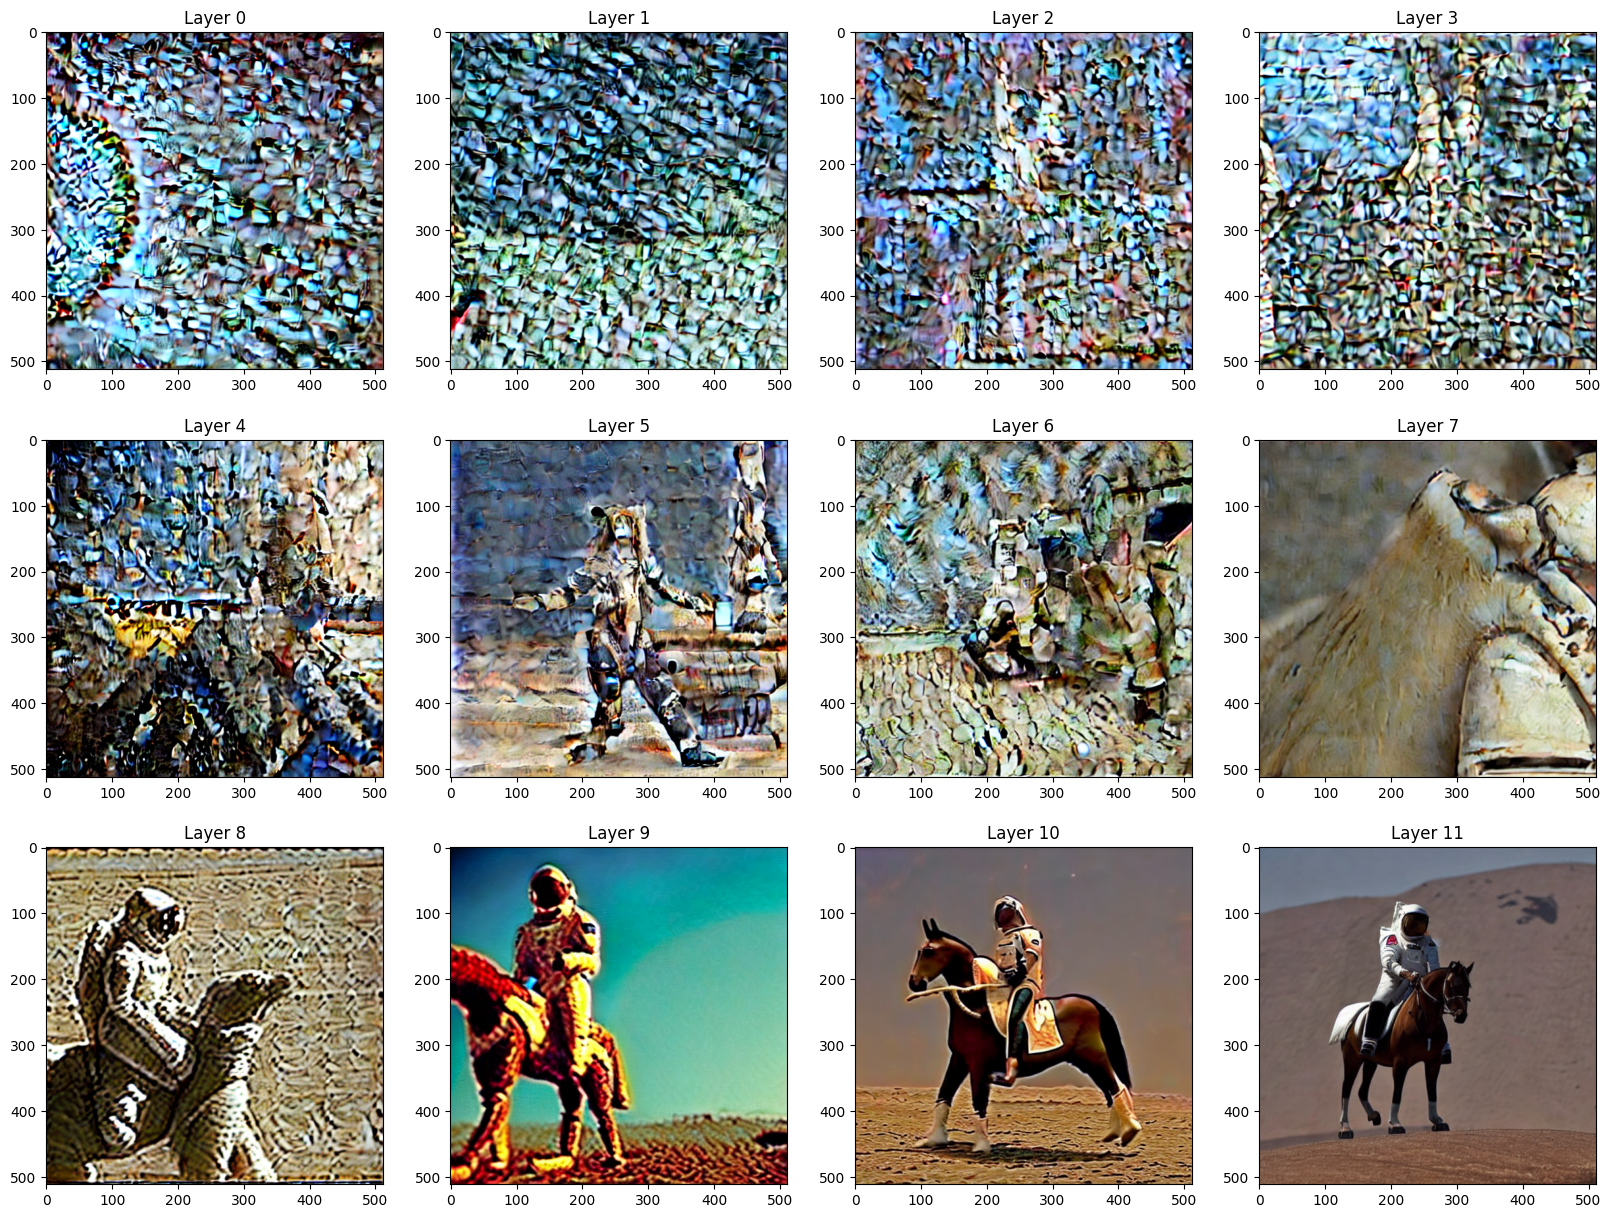

In [30]:
# Code to plot all 12 images in a grid
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(tuned_images[i])
    ax.set_title(f"Layer {i}")
plt.show()